#  1. Import Libraries


In [ ]:
# Import necessary libraries for Neural Networks (PyTorch), Randomness, and Visualization
import numpy as np           # For mathematical operations and arrays
import torch                 # PyTorch for building neural networks
import torch.nn as nn        # Neural network layers
import torch.optim as optim   # Optimizers for updating the weights
import random                # Randomness for city generation and action selection
import matplotlib.pyplot as plt  # For plotting and visualization


In [ ]:
import shap

# 2. Traveling Salesman Problem (TSP)

The Traveling Salesman Problem (TSP) asks the question: "Given a list of cities and the distances between them, what is the shortest possible route that visits each city exactly once and returns to the origin city?"

We will solve this using Deep Reinforcement Learning with a Q-learning-based agent.


# 3. City Class for TSP


In [ ]:
# City Class
# This class represents each city in the TSP problem by its coordinates (x, y).
# It also includes a method to calculate the Euclidean distance to another city.

class City:
    def __init__(self, x, y, demand):
        """
        Initialize the city with its x and y coordinates.
        """
        self.x = x
        self.y = y
        self.demand = demand

    def distance_to(self, city):
        """
        Compute the Euclidean distance between this city and another city.
        Euclidean distance formula: sqrt((x2 - x1)^2 + (y2 - y1)^2)
        """
        return np.sqrt((self.x - city.x)**2 + (self.y - city.y)**2)


# 4. Deep Q-Network (DQN) Definition


In [ ]:
# Neural Network Model for Q-learning
# This model will approximate the Q-values for each possible action (city to visit next).
# The network has three fully connected layers with ReLU activations.

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # BatchNorm applied only when batch > 1
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        if x.shape[0] > 1:  # Apply BatchNorm only if batch size > 1
            x = torch.relu(self.bn1(self.fc1(x)))
            x = torch.relu(self.bn2(self.fc2(x)))
        else:
            x = torch.relu(self.fc1(x))  # No BatchNorm if batch size = 1
            x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 5. TSP Agent Setup (Reinforcement Learning)


In [ ]:
# TSP Agent for Reinforcement Learning
# This agent interacts with the environment, makes decisions, stores experiences, and learns from them.
# The agent uses Q-learning to find the optimal tour that minimizes the travel distance.

class TSPAgent:
    def __init__(self, num_cities, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.001):
        """
        Initialize the agent with hyperparameters for Q-learning:
        - gamma: discount factor (how much future rewards are considered)
        - epsilon: initial exploration rate (for epsilon-greedy strategy)
        - epsilon_decay: how quickly exploration rate decays
        - epsilon_min: minimum exploration rate
        - lr: learning rate for optimizer
        """
        input_size = num_cities + 2 * num_cities + num_cities  # New input size
        output_size = num_cities  # Actions (choosing the next city)

        self.num_cities = num_cities
        self.gamma = gamma  # Discount factor for future rewards
        self.epsilon = epsilon  # Exploration rate for epsilon-greedy policy
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = []  # Memory buffer to store experiences
        self.batch_size = 32  # Number of experiences to sample for training
        self.memory_capacity = 10000  # Max capacity of memory buffer
        self.q_network = DQN(input_size, output_size)  # Updated input size  # Initialize the Q-network
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)  # Optimizer for training
        self.loss_fn = nn.MSELoss()  # Mean Squared Error loss for training

    def choose_action(self, state):
        """
        Choose an action (next city to visit) using epsilon-greedy strategy.
        - With probability epsilon, choose a random action (exploration).
        - Otherwise, choose the action with the highest Q-value (exploitation).
        """
        if np.random.rand() < self.epsilon:  # Exploration
            return random.randint(0, self.num_cities - 1)  # Choose a random city to visit
        else:  # Exploitation
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
            with torch.no_grad():  # No gradient calculation needed
                q_values = self.q_network(state_tensor)  # Get Q-values for current state
            return torch.argmax(q_values).item()  # Choose the action with the highest Q-value

    def store_experience(self, state, action, reward, next_state, done):
        """
        Store the agent's experience (state, action, reward, next_state, done) in memory for experience replay.
        If memory exceeds its capacity, the oldest experience is removed.
        """
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0)  # Remove the oldest experience if memory is full
        self.memory.append((state, action, reward, next_state, done))  # Add new experience

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.q_network(next_state_tensor))

            q_value = self.q_network(state_tensor)[0, action]
            loss = self.loss_fn(q_value, torch.tensor(target, dtype=torch.float32))

            # Feature Regularization: Ensure all features contribute
            feature_loss = 0.001 * torch.sum(torch.abs(self.q_network(state_tensor)))  # Encourage feature use
            total_loss = loss + feature_loss  # Combine Q-learning loss with feature importance loss

            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def explain_decision(self, state):
        """
        Use SHAP KernelExplainer to explain the decision-making process of the Q-network.
        """
        self.q_network.eval()  # Set to evaluation mode

        # Convert state to NumPy array (SHAP needs NumPy format)
        state_numpy = np.array(state, dtype=np.float32).reshape(1, -1)  # Ensure correct shape
        # Generate background dataset for SHAP (random states)
        background = np.random.randn(50, len(state))  # 50 random states in NumPy format

        # Define a wrapper function for SHAP
        def model_wrapper(x):
            x_tensor = torch.tensor(x, dtype=torch.float32)  # Convert NumPy input to tensor
            with torch.no_grad():  # Disable gradient tracking
                return self.q_network(x_tensor).detach().numpy()  # Convert output to NumPy

        # Initialize SHAP KernelExplainer
        explainer = shap.KernelExplainer(model_wrapper, background)
        # Compute SHAP values
        shap_values = explainer(state_numpy)  # This is a SHAP Explanation object

        # Convert feature labels to a NumPy array
        feature_labels = np.array(
            ["Visited_" + str(i) for i in range(self.num_cities)] +
            ["X_Coord_" + str(i) for i in range(self.num_cities)] +
            ["Y_Coord_" + str(i) for i in range(self.num_cities)] +
            ["Demand_" + str(i) for i in range(self.num_cities)]
        )

        # Ensure base_values is properly formatted as an array
        base_values = np.array([shap_values.base_values])  # ✅ Fix: Wrap in an array

        # Create a SHAP Explanation object
        shap_explanation = shap.Explanation(
            values=shap_values.values[0],  # Extract 1D SHAP values for the state
            base_values=base_values,  # ✅ Use the corrected base values
            data=state_numpy[0],  # The actual state features
            feature_names=feature_labels  # Feature names
        )

        # Plot SHAP bar plot for this state
        shap.plots.bar(shap_explanation)




    def explain_episode(self, env, save_plot=False):
        """
        Compute SHAP values for all states in one episode and generate a beeswarm plot.
        If save_plot=True, the SHAP beeswarm plot is saved as an image.
        """
        self.q_network.eval()  # Set to evaluation mode

        all_shap_values = []  # Store SHAP values for each step
        all_states = []  # Store states for reference

        state = env.reset()  # Start a new episode
        done = False

        while not done:
            all_states.append(state)  # Store current state

            # Convert state to NumPy array
            state_numpy = np.array(state, dtype=np.float32).reshape(1, -1)

            # Generate background dataset for SHAP (random states)
            background = np.random.randn(50, len(state))  # Random normal background

            # Define SHAP-compatible model function
            def model_wrapper(x):
                x_tensor = torch.tensor(x, dtype=torch.float32)
                with torch.no_grad():
                    return self.q_network(x_tensor).detach().numpy()

            # Compute SHAP values for the state
            explainer = shap.KernelExplainer(model_wrapper, background)
            shap_values = explainer.shap_values(state_numpy)

            all_shap_values.append(shap_values)  # Store SHAP results

            # Take action and get next state
            action = self.choose_action(state)
            next_state, _, done = env.step(action)
            state = next_state  # Move to next state

        #self.explain_decision(state)  # Explain the final

        if all_shap_values and all_states:
            # Convert lists of SHAP values and states to numpy arrays
            all_shap_values = np.vstack(all_shap_values)  # Shape: (num_steps, num_features)
            all_states = np.vstack(all_states)  # Shape: (num_steps, num_features)

            # Ensure SHAP values match the state dimensions
            if all_shap_values.shape[1] > all_states.shape[1]:
                all_shap_values = all_shap_values[:, :-1]  # Remove extra column if needed

            # Convert feature names to NumPy array to avoid indexing issues
            feature_names = np.array(
                [f"Visited_{i}" for i in range(self.num_cities)] +
                [f"X_Coord_{i}" for i in range(self.num_cities)] +
                [f"Y_Coord_{i}" for i in range(self.num_cities)] +
                [f"Demand_{i}" for i in range(self.num_cities)]
            )

            # Select the most relevant SHAP values (first action output or mean across actions)
            if len(all_shap_values.shape) == 3:
                all_shap_values = np.mean(all_shap_values, axis=2)  # Average over actions

            # Create a SHAP Explanation object (2D shape)
            shap_explanation = shap.Explanation(
                values=all_shap_values,
                base_values=np.zeros(all_shap_values.shape[0]),  # Base values (zero for visualization)
                data=all_states,
                feature_names=feature_names
            )

            # Generate and display the SHAP beeswarm plot
            shap.plots.beeswarm(shap_explanation)


            # Generate and display the SHAP beeswarm plot
            shap.plots.beeswarm(shap_explanation)

            if save_plot:
                plt.savefig("shap_beeswarm_plot.png")
                print("SHAP beeswarm plot saved as shap_beeswarm_plot.png")
        else:
            print("No SHAP values to plot.")



# 8. TSP Environment Class (Simulating the Problem)


In [ ]:
# TSP Environment
# This environment simulates the cities and their connections.
# It interacts with the agent and provides rewards based on actions (city visits).

class TSPEnvironment:
    def __init__(self, cities):
        """
        Initialize the environment with a list of cities.
        It also tracks the current state (cities visited), total distance, and the current city.
        """
        self.cities = cities
        self.num_cities = len(cities)
        self.current_state = []  # The current state will store which cities have been visited
        self.current_city = None  # The current city the agent is located in
        self.visited = []  # List of visited cities
        self.total_distance = 0  # Total distance traveled by the agent

    def get_state(self):
        """
        Construct the state representation:
        - Visited (binary vector)
        - Coordinates (normalized)
        - Demand (binary)
        """
        visited_state = np.zeros(self.num_cities)
        for city in self.visited:
            visited_state[city] = 1

        # Normalize coordinates between 0 and 1
        x_coords = np.array([city.x for city in self.cities])
        y_coords = np.array([city.y for city in self.cities])

        x_coords = (x_coords - x_coords.min()) / (x_coords.max() - x_coords.min())  # Normalize X
        y_coords = (y_coords - y_coords.min()) / (y_coords.max() - y_coords.min())  # Normalize Y

        coords = np.concatenate((x_coords, y_coords))  # Flattened coordinates
        demand_status = np.array([1 if city.demand > 0 else 0 for city in self.cities])  # Demand binary values

        # Concatenate all features into a single state representation
        state = np.concatenate((visited_state, coords, demand_status))
        return state


    def reset(self):
        """
        Reset the environment for a new episode.
        """
        self.current_city = random.randint(0, self.num_cities - 1)  # Start from a random city
        self.visited = [self.current_city]  # Mark the start city as visited
        self.total_distance = 0  # Reset total distance traveled
        self.current_state = self.get_state()  # Get updated state representation
        return self.current_state

    def step(self, action):
        """
        Take a step in the environment.
        """
        if action in self.visited:
            reward = -10  # Negative reward for revisiting a city
        else:
            reward = -self.cities[self.current_city].distance_to(self.cities[action])  # Negative distance as reward
            self.total_distance += abs(reward)
            self.visited.append(action)  # Mark the city as visited

        self.current_city = action  # Move to the new city
        self.current_state = self.get_state()  # Update the state representation

        done = len(self.visited) == self.num_cities  # Check if all cities have been visited
        if done:
            # Add the return trip to the starting city
            reward -= self.cities[self.current_city].distance_to(self.cities[self.visited[0]])
            self.total_distance += abs(reward)

        return self.current_state, reward, done


    # Plotting the solution learned by the agent
    def plot_solution(self, cities, path):
      """
      Visualize the final path learned by the agent. The cities will be connected based on the path found.
      """
      # Convert indices to City objects
      city_path = [cities[int(i)] for i in path]  # Convert path indices to City objects

      # Extract x and y coordinates
      x_coords = [city.x for city in city_path]
      y_coords = [city.y for city in city_path]

      # Ensure the path returns to the starting city
      x_coords.append(x_coords[0])
      y_coords.append(y_coords[0])

      # Plot the solution
      plt.plot(x_coords, y_coords, 'bo-', markerfacecolor='red')  # Path with cities marked
      plt.xlabel('X Coordinate')
      plt.ylabel('Y Coordinate')
      plt.title('Traveling Salesman Path')
      plt.grid(True)
      plt.show()

# 10. Training Function for the TSP Agent


In [ ]:
# Function to train the agent for multiple episodes of interaction with the environment
def train_tsp_agent(cities, episodes=1000):
    """
    Train the TSP agent using Q-learning for a given number of episodes.
    The agent interacts with the environment, learns from its experiences, and improves its policy.
    """
    env = TSPEnvironment(cities)  # Create the environment with the cities
    agent = TSPAgent(num_cities=len(cities))  # Initialize the Q-learning agent

    for episode in range(episodes):
        state = env.reset()  # Reset the environment at the beginning of each episode
        done = False
        total_reward = 0  # Track total reward (negative total distance)

        while not done:
            action = agent.choose_action(state)  # Agent chooses the next city (action)
            next_state, reward, done = env.step(action)  # Environment responds with next state and reward
            agent.store_experience(state, action, reward, next_state, done)  # Store experience for replay
            state = next_state  # Move to the next state
            # Explain the decision made by the agent
#            agent.explain_decision(state)
            total_reward += reward  # Accumulate the reward (minimizing negative distance)
            agent.train()  # Train the agent based on stored experiences
        # Save policy
        torch.save(agent.q_network.state_dict(), "tsp_dql.pt")

        if episode % 10 == 0:
            print(f"Episode {episode+1}, Total Reward: {total_reward}, Total Distance: {env.total_distance}")
            print("env distance", env.total_distance)
        #env.plot_solution(cities,env.visited)


# Function to train the agent for multiple episodes of interaction with the environment
def test_tsp_agent(cities):
    """
    Train the TSP agent using Q-learning for a given number of episodes.
    The agent interacts with the environment, learns from its experiences, and improves its policy.
    """
    env = TSPEnvironment(cities)  # Create the environment with the cities
    agent = TSPAgent(num_cities=len(cities))  # Initialize the Q-learning agent
    agent.q_network.load_state_dict(torch.load("tsp_dql.pt"))
    agent.q_network.eval()    # switch model to evaluation mode

    print('------------ Policy (trained) ------------')
    test_state = env.get_state()
    print("State shape:", len(test_state))
    print("State values:", test_state)


    state = env.reset()  # Reset the environment at the beginning of each episode
    done = False
    while not done:
        action = agent.choose_action(state)  # Agent chooses the next city (action)
        next_state, reward, done = env.step(action)  # Environment responds with next state and reward
        state = next_state  # Move to the next state
        # Explain the decision made by the agent
        agent.explain_decision(state)

    print("env distance", env.total_distance)
    env.plot_solution(cities,env.visited)





# 12. Example Execution


In [ ]:
# Example execution: Define a set of random cities and train the TSP agent

# Generate a random set of cities for the TSP problem
num_cities = 5
cities = [City(x=random.randint(0, 100), y=random.randint(0, 100), demand=random.randint(0, 100)) for _ in range(num_cities)]

# Train the Q-learning agent for 500 episodes
train_tsp_agent(cities, episodes=100)


Episode 1, Total Reward: -360.9645966629016, Total Distance: 243.4145581420775
env distance 243.4145581420775


<ipython-input-5-3e0b232144f7>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = self.loss_fn(q_value, torch.tensor(target, dtype=torch.float32))


Episode 11, Total Reward: -314.1012131536892, Total Distance: 382.21011149440324
env distance 382.21011149440324
Episode 21, Total Reward: -225.71395143582401, Total Distance: 271.9848926408611
env distance 271.9848926408611
Episode 31, Total Reward: -362.89410457221675, Total Distance: 352.9274286514312
env distance 352.9274286514312
Episode 41, Total Reward: -320.0475462683829, Total Distance: 339.69631261760856
env distance 339.69631261760856
Episode 51, Total Reward: -276.58909826367915, Total Distance: 276.6224223428937
env distance 276.6224223428937
Episode 61, Total Reward: -229.53076002226737, Total Distance: 241.98072150144327
env distance 241.98072150144327
Episode 71, Total Reward: -289.9899815124881, Total Distance: 358.0988798532021
env distance 358.0988798532021
Episode 81, Total Reward: -389.76867150918315, Total Distance: 309.4174378584088
env distance 309.4174378584088
Episode 91, Total Reward: -324.3597848492793, Total Distance: 256.8097463284553
env distance 256.8097

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

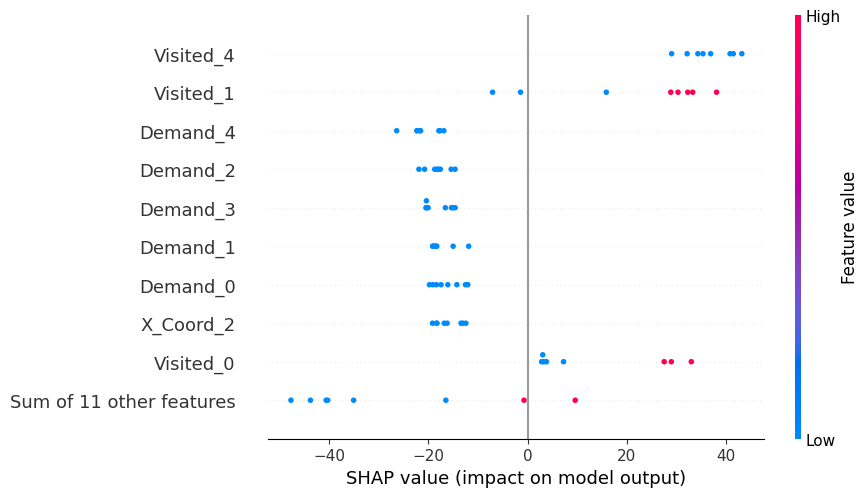

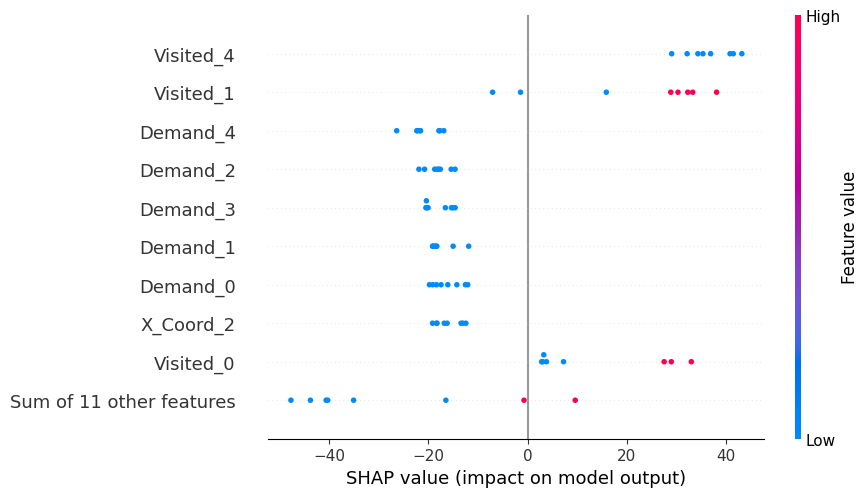

In [ ]:
# Test the Q-learning agent
#test_tsp_agent(cities)

# Generate a random set of cities for the TSP problem
num_cities = 5
cities = [City(x=random.randint(0, 100), y=random.randint(0, 100), demand=random.randint(0, 100)) for _ in range(num_cities)]

env = TSPEnvironment(cities)  # Create the environment with the cities
agent = TSPAgent(num_cities=len(cities))  # Initialize the Q-learning agent
agent.q_network.load_state_dict(torch.load("tsp_dql.pt"))
agent.explain_episode(env)
